# Data loading and preprocessing, utility function definition

## Imports and data loading

In [2]:
import gc
import itertools
import time

import numpy as np
import pandas as pd
import seaborn as sns
from IPython.core.debugger import set_trace
from pandas.tseries.offsets import MonthEnd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import lightgbm as lgbm
# A few functions are imported from a utility script, have a look at it if you like.
import futuresalesutility as fu

Load the data and convert the date column in the training data to the datetime dtype to enable datetime operations.

In [3]:
item_categories_extra = pd.read_csv('../input/predict-future-sales-extra/item_categories_enhanced.csv')
item_categories_extra = item_categories_extra.drop(columns=['category_name', 'supercategory', 'platform'])
items = pd.read_csv("../input/competitive-data-science-predict-future-sales/items.csv")
shops = pd.read_csv("../input/competitive-data-science-predict-future-sales/shops.csv")
train = pd.read_csv("../input/competitive-data-science-predict-future-sales/sales_train.csv")
test = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")

train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")

## Data cleaning

* Correct duplicate shop names
* Drop a few duplicate items in the training set
* Drop shops which are not in the test set (these are only a few of these and they tend to be strange in some way, e.g. low sales, not operating for long)+
* Drop categories 8 and 80 as these are for tickets to an annual exhibition which are not sold in the test month
* Remove outliers and negative values for the item_cnt_day and item_price features (these are few in number but cause problems when generating some features)

In [4]:
# Correct shop labels
train.loc[train.shop_id == 0, "shop_id"] = 57
train.loc[train.shop_id == 1, "shop_id"] = 58
train.loc[train.shop_id == 11, "shop_id"] = 10
# Drop shops not in test set
testshops = test.shop_id.unique()
train = train.loc[train["shop_id"].isin(testshops), :]
del testshops
# Drop duplicates
train = train.drop_duplicates()
# Drop categories 8 and 80
train = train.merge(items[["item_id", "item_category_id"]], on="item_id", how="left")
train = train[~train.item_category_id.isin([8, 80])]
# Clip outliers and  remove items with a negative sales price or item_cnt_day
train = train.query("(item_price>0) & (item_cnt_day>0)")
train.loc[:, "item_price"] = train.loc[:, "item_price"].clip(0, train["item_price"].quantile(0.9999))
train.loc[:, "item_cnt_day"] = train.loc[:, "item_cnt_day"].clip(0, train["item_cnt_day"].quantile(0.999))

## Preprocessing

Create a training matrix similar to the test items by aggregating the sales to the month level and creating items for every possible combination of shops and items featured in each individual month of the training data. Additionally, concatenate test to train data to enable creation of features for the test items.

In [5]:
def create_testlike_train(sales_train, test=None):
    # Create a date_block_num / item_id / shop_id index using all combinations of item_id and shop_id occurring within each date_block
    # Optionally concatenate the test items to the end
    indexlist = []
    for i in sales_train.date_block_num.unique():
        x = itertools.product(
            [i],
            sales_train.loc[sales_train.date_block_num == i].shop_id.unique(),
            sales_train.loc[sales_train.date_block_num == i].item_id.unique(),
        )
        indexlist.append(np.array(list(x)))
    df = pd.DataFrame(
        data=np.concatenate(indexlist, axis=0), columns=["date_block_num", "shop_id", "item_id"],
    )

    # Add revenue column to sales_train
    sales_train["item_revenue_day"] = sales_train["item_price"] * sales_train["item_cnt_day"]
    # Aggregate item_id / shop_id item_cnts and revenue at the month level
    sales_train_grouped = sales_train.groupby(["date_block_num", "shop_id", "item_id"]).agg(
        item_cnt_month=pd.NamedAgg(column="item_cnt_day", aggfunc="sum"),
        item_revenue_month=pd.NamedAgg(column="item_revenue_day", aggfunc="sum"),
    )

    # Merge the grouped data with the index
    df = df.merge(sales_train_grouped, how="left", on=["date_block_num", "shop_id", "item_id"],)

    if test is not None:
        test["date_block_num"] = 34
        test["date_block_num"] = test["date_block_num"].astype(np.int8)
        test["shop_id"] = test.shop_id.astype(np.int8)
        test["item_id"] = test.item_id.astype(np.int16)
        test = test.drop(columns="ID")

        df = pd.concat([df, test[["date_block_num", "shop_id", "item_id"]]])

    # Fill empty item_cnt entries with 0
    df.item_cnt_month = df.item_cnt_month.fillna(0)
    df.item_revenue_month = df.item_revenue_month.fillna(0)

    return df

In [5]:
matrix = create_testlike_train(train, test)
matrix = fu.reduce_mem_usage(matrix, silent=False)
oldcols = matrix.columns

Memory usage of dataframe is 405.26 MB
Memory usage after optimization is: 151.97 MB
Decreased by 62.5%


# Feature engineering  
In this section predictor feature columns are generated and added to the matrix

## Time features
Time-dependent features
* Item and shop age in months
* Binary features for new items and shops (i.e. first month of appearance)
* Item and shop age in days
* Number of days in the current month
* Average item count per day in the last month - useful for new items which may not have been available for the full calendar month
* Days since last sale of an item in each shop and all shops

In [80]:
def add_time_features(m, train, correct_item_cnt_day=False):
    from pandas.tseries.offsets import Day, MonthBegin, MonthEnd

    def item_shop_age_months(m):
        m["item_age"] = m.groupby("item_id")["date_block_num"].transform(
            lambda x: x - x.min()
        )
        # Sales tend to plateau after 12 months 
        m["item_age_max_12"] = m["item_age"].clip(upper=12)
        m["new_item"] = m["item_age"] == 0
        m["new_item"] = m["new_item"].astype("int8")
        m["shop_age"] = (
            m.groupby("shop_id")["date_block_num"]
            .transform(lambda x: x - x.min())
            .astype("int8")
        )
        m["new_shop"] = m.shop_age == 0
        m["new_shop"] = m["new_shop"].astype("int8")
        return m

    m = item_shop_age_months(m)

    # Add dummy values for the test month so that features are created correctly
    dummies = m.loc[m.date_block_num == 34, ["date_block_num", "shop_id", "item_id"]]
    dummies = dummies.assign(
        date=pd.to_datetime("2015-11-30"),
        item_price=1,
        item_cnt_day=0,
        item_revenue_day=0,
    )
    train = pd.concat([train, dummies])
    del dummies

    month_last_day = train.groupby("date_block_num").date.max().rename("month_last_day")
    month_last_day[~month_last_day.dt.is_month_end] = (
        month_last_day[~month_last_day.dt.is_month_end] + MonthEnd()
    )
    month_first_day = train.groupby("date_block_num").date.min().rename("month_first_day")
    month_first_day[~month_first_day.dt.is_month_start] = (
        month_first_day[~month_first_day.dt.is_month_start] - MonthBegin()
    )
    month_length = (month_last_day - month_first_day + Day()).rename("month_length")
    first_shop_date = train.groupby("shop_id").date.min().rename("first_shop_date")
    first_item_date = train.groupby("item_id").date.min().rename("first_item_date")
    first_shop_item_date = (
        train.groupby(["shop_id", "item_id"]).date.min().rename("first_shop_item_date")
    )

    m = m.merge(month_first_day, left_on="date_block_num", right_index=True, how="left")
    m = m.merge(month_last_day, left_on="date_block_num", right_index=True, how="left")
    m = m.merge(month_length, left_on="date_block_num", right_index=True, how="left")
    m = m.merge(first_shop_date, left_on="shop_id", right_index=True, how="left")
    m = m.merge(first_item_date, left_on="item_id", right_index=True, how="left")
    m = m.merge(
        first_shop_item_date, left_on=["shop_id", "item_id"], right_index=True, how="left"
    )

    # Calculate how long the item was sold for in each month and use this to calculate average sales per day
    m["shop_open_days"] = m["month_last_day"] - m["first_shop_date"] + Day()
    m["item_first_sale_days"] = m["month_last_day"] - m["first_item_date"] + Day()
    m["item_in_shop_days"] = (
        m[["shop_open_days", "item_first_sale_days", "month_length"]].min(axis=1).dt.days
    )
    m = m.drop(columns="item_first_sale_days")
    m["item_cnt_day_avg"] = m["item_cnt_month"] / m["item_in_shop_days"]
    m["month_length"] = m["month_length"].dt.days

    # Calculate the time differences from the beginning of the month so they can be used as features without lagging
    m["shop_open_days"] = m["month_first_day"] - m["first_shop_date"]
    m["first_item_sale_days"] = m["month_first_day"] - m["first_item_date"]
    m["first_shop_item_sale_days"] = m["month_first_day"] - m["first_shop_item_date"]
    m["shop_open_days"] = m["shop_open_days"].dt.days.fillna(0).clip(lower=0)
    m["first_item_sale_days"] = m["first_item_sale_days"].dt.days.fillna(0).clip(lower=0)
    m["first_shop_item_sale_days"] = (
        m["first_shop_item_sale_days"].dt.days.fillna(0).clip(lower=0)
    )

    # Change the first sale date feature to integer format indexed from the first day in the training data
    m["first_day"] = train.date.min()
    m["first_item_date"] = (m["first_item_date"] - m["first_day"]).dt.days
    m["first_shop_item_date"] = (m["first_shop_item_date"] - m["first_day"]).dt.days

    # Add days since last sale
    def last_sale_days(matrix):
        last_shop_item_dates = []
        last_item_dates = []
        for dbn in tqdm(range(1, 35)):
            lsid_temp = (
                train.query(f"date_block_num<{dbn}")
                .groupby(["shop_id", "item_id"])
                .date.max()
                .rename("last_shop_item_sale_date")
                .reset_index()
            )
            lid_temp = (
                lsid_temp.groupby("item_id")
                .last_shop_item_sale_date.max()
                .rename("last_item_sale_date")
                .reset_index()
            )
            lsid_temp["date_block_num"] = dbn
            lid_temp["date_block_num"] = dbn
            last_shop_item_dates.append(lsid_temp)
            last_item_dates.append(lid_temp)
        last_shop_item_dates = pd.concat(last_shop_item_dates)
        last_item_dates = pd.concat(last_item_dates)
        matrix = matrix.merge(
            last_shop_item_dates, on=["date_block_num", "shop_id", "item_id"], how="left"
        )
        matrix = matrix.merge(
            last_item_dates, on=["date_block_num", "item_id"], how="left"
        )

        def days_since_last_feat(m, feat_name, date_feat_name, missingval):
            m[feat_name] = (m["month_first_day"] - m[date_feat_name]).dt.days
            m.loc[m[feat_name] > 2000, feat_name] = missingval
            m.loc[m[feat_name].isna(), feat_name] = missingval
            return m

        matrix = days_since_last_feat(
            matrix, "last_shop_item_sale_days", "last_shop_item_sale_date", 9999
        )
        matrix = days_since_last_feat(
            matrix, "last_item_sale_days", "last_item_sale_date", 9999
        )
        matrix = matrix.drop(columns=["last_shop_item_sale_date", "last_item_sale_date"])
        return matrix

    m = last_sale_days(m)
    # Month
    m["month"] = m["month_first_day"].dt.month

    m = m.drop(
        columns=[
            "first_day",
            "month_first_day",
            "month_last_day",
            "first_shop_date",
            "item_in_shop_days",
            "first_shop_item_date",
        ]
    )

    if correct_item_cnt_day == True:
        m["item_cnt_month_original"] = m["item_cnt_month"]
        m["item_cnt_month"] = m["item_cnt_day_avg"] * m["month_length"]

    return m

In [7]:
matrix = add_time_features(matrix, train, False)
print("Time features created")


Time features created


Additionally clip the corrected monthly item counts to remove the effect of outliers, but save the unclipped version for use as a feature.

In [8]:
matrix['item_cnt_month_unclipped'] = matrix.loc[:,'item_cnt_month']
matrix['item_cnt_month'] = matrix['item_cnt_month'].clip(lower=0, upper=20)

## Price features  
* Last mean price for a month in which the item was sold
* Difference of the last price from the historical mean (calculated with an expanding window)
* Difference of the last mean price from the first sale price in the data (proxy for the release price)
* Difference of the last mean price from the mean for the category in the same month.  

It can be assumed that item price is related to sales, both in absolute terms and relative to other items of the same category and the same item's earlier price.

In [9]:
def add_price_features(matrix, train):
    # Get mean prices per month from train dataframe
    price_features = train.groupby(["date_block_num", "item_id"]).item_price.mean()
    price_features = pd.DataFrame(price_features)
    price_features = price_features.reset_index()
    # Calculate expanding mean and join to dataframe
    emp = price_features.groupby("item_id").item_price.expanding().mean()
    emp = emp.reset_index(level=0)
    price_features["exp_mean_price"] = emp["item_price"]
    del emp
    # Get first sale price for item
    price_features["start_price"] = price_features.groupby(
        "item_id"
    ).item_price.transform(lambda x: x.to_numpy()[0])
    # Calculate  differences from start and mean prices
    price_features["norm_diff_exp_mean_price"] = (
        price_features["item_price"] - price_features["exp_mean_price"]
    ) / price_features["exp_mean_price"]
    price_features["norm_diff_start_price"] = (
        price_features["item_price"] - price_features["start_price"]
    ) / price_features["start_price"]
    # Calculate normalized differences from start and mean prices
    price_features["norm_diff_exp_mean_price"] = (
        price_features["item_price"] - price_features["exp_mean_price"]
    ) / price_features["exp_mean_price"]
    # Calculate normalized differenced from mean category price per month
    price_features = price_features.merge(
        items[["item_id", "item_category_id"]], how="left", on="item_id"
    )
    price_features["norm_diff_cat_price"] = price_features.groupby(
        ["date_block_num", "item_category_id"]
    )["item_price"].transform(lambda x: (x - x.mean()) / x.mean())
    # Retain only the necessary features
    price_features = price_features[
        [
            "date_block_num",
            "item_id",
            "item_price",
            "norm_diff_exp_mean_price",
            "norm_diff_start_price",
            "norm_diff_cat_price",
        ]
    ]

    features = [
        "item_price",
        "norm_diff_exp_mean_price",
        "norm_diff_start_price",
        "norm_diff_cat_price",
    ]
    newnames = ["last_" + f for f in features]
    aggs = {f: "last" for f in features}
    renames = {f: "last_" + f for f in features}

    features = []
    for dbn in tqdm(range(1, 35)):
        f_temp = (
            price_features.query(f"date_block_num<{dbn}")
            .groupby("item_id")
            .agg(aggs)
            .rename(columns=renames)
        )
        f_temp["date_block_num"] = dbn
        features.append(f_temp)
    features = pd.concat(features).reset_index()

    matrix = matrix.merge(features, on=["date_block_num", "item_id"], how="left")
    matrix[newnames] = matrix[newnames].fillna(999999)
    return matrix


matrix = add_price_features(matrix, train)

## Categorical features

Categorical features provided with the data, e.g. item category, and custom categories extracted from category and shop names, e.g. "video games", "music", "PS4"

In [10]:
matrix = matrix.merge(items.drop(columns='item_name'), on='item_id', how='left')
matrix = matrix.merge(item_categories_extra, on='item_category_id', how='left')

City that the shop is located in
(from https://www.kaggle.com/dlarionov/feature-engineering-xgboost)

In [11]:
def add_city_codes(matrix, shops):
    shops.loc[
        shops.shop_name == 'Сергиев Посад ТЦ "7Я"', "shop_name"
    ] = 'СергиевПосад ТЦ "7Я"'
    shops["city"] = shops["shop_name"].str.split(" ").map(lambda x: x[0])
    shops.loc[shops.city == "!Якутск", "city"] = "Якутск"
    shops["city_code"] = shops["city"].factorize()[0]
    shop_labels = shops[["shop_id", "city_code"]]
    matrix = matrix.merge(shop_labels, on='shop_id', how='left')
    return matrix

matrix = add_city_codes(matrix, shops)

In [12]:
gc.collect()
matrix, oldcols = fu.shrink_mem_new_cols(matrix, oldcols)  # Use this function periodically to downcast dtypes to save memory
# matrix.to_pickle("matrixcheckpoint_1.pk1")
print("Saved matrixcheckpoint 1")

Saved matrixcheckpoint 1


## Rolling mean features
Sales from previous months are a good predictor of future sales, but chance fluctuations mean that an average of several previous months may be more reliable than counts from a single month. Pandas has several windowing functions for time series built in, 3 of which are demonstrated below : expanding (all previous timepoints), rolling (a fixed number of previous timepoints) and exponential (a weighted window with weights which decrease with time distance before the current point). These are compared below.

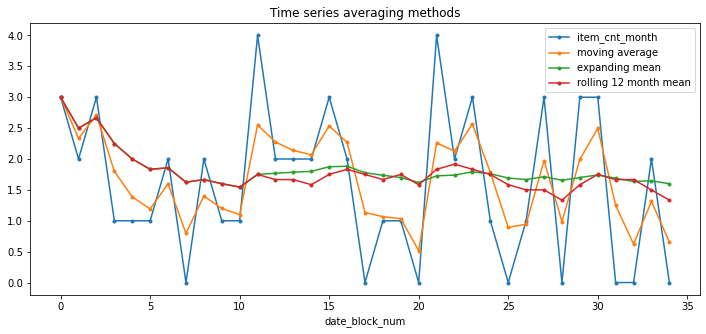

In [13]:
shop_id = 16
item_id = 482
im = matrix.query(f"shop_id=={shop_id} & item_id=={item_id}")[['date_block_num', 'item_cnt_month']]
im['moving average'] = im['item_cnt_month'].ewm(halflife=1).mean()
im['expanding mean'] = im['item_cnt_month'].expanding().mean()
im['rolling 12 month mean'] = im['item_cnt_month'].rolling(window=12, min_periods=1).mean()
im = im.set_index('date_block_num')
ax = im.plot(figsize=(12,5), marker='.', title='Time series averaging methods')

A weakness of the pandas windowed functions is that they do not insert zeros for missing timepoints and our data matrix does not contain entries for month in which items were not sold.  
This is solved here by creating a sales matrix which contains entries for all items in all months, and using this to generate windowed features. Entries for months prior to an items availability are set to NaN so that they are not included in calculations.  
Because of the high memory requirements of the functions and dataframes used to create windowed features, these functions are created early in the script before the feature dataframe has grown larger.

In [14]:
def create_full_train_test(sales_train, test, clip_target=20.0):
    # Create a train set with all items and all shops in all date blocks.
    # Add revenue column to sales_train
    sales_train["item_revenue_day"] = sales_train["item_price"] * sales_train["item_cnt_day"]
    # Aggregate item_id / shop_id item_cnts and revenue at the month level
    sales_train_grouped = sales_train.groupby(["date_block_num", "shop_id", "item_id"]).agg(
        item_cnt_month=pd.NamedAgg(column="item_cnt_day", aggfunc="sum"),
        item_revenue_month=pd.NamedAgg(column="item_revenue_day", aggfunc="sum"),
    )
    # Create sets of items, shops and date blocks
    item_ids = set(sales_train.item_id).union(set(test.item_id))
    shop_ids = set(sales_train.shop_id).union(set(test.shop_id))
    date_block_nums = set(sales_train.date_block_num).union(set([34]))
    # Create all permutations as indexes
    indexdataframe = pd.DataFrame(
        np.array(list(itertools.product(date_block_nums, item_ids, shop_ids))),
        columns=["date_block_num", "item_id", "shop_id"],
    )
    m = indexdataframe.merge(sales_train_grouped, how="left", on=["date_block_num", "item_id", "shop_id"])
    m.item_cnt_month = m.item_cnt_month.fillna(0)
    m.item_revenue_month = m.item_revenue_month.fillna(0)
    shop_first_sales = train.groupby("shop_id").date_block_num.min().rename("shop_first_month")
    shop_last_sales = train.groupby("shop_id").date_block_num.max().rename("shop_last_month")
    item_first_sales = train.groupby("item_id").date_block_num.min().rename("item_first_month")
    m = m.merge(shop_first_sales, on="shop_id", how="left")
    m = m.merge(shop_last_sales, on="shop_id", how="left")
    m = m.merge(item_first_sales, on="item_id", how="left")
    mask = (
        (m.date_block_num < m.shop_first_month)
        | (m.date_block_num < m.item_first_month)
        | (m.date_block_num > m.shop_last_month)
    )
    m = m.drop(columns=["shop_first_month", "shop_last_month", "item_first_month"])
    m.loc[mask, ["item_cnt_month", "item_revenue_month"]] = np.nan
    
    if clip_target is not None:
        m['item_cnt_month'] = m['item_cnt_month'].clip(upper=clip_target)
    m = fu.reduce_mem_usage(m)
    return m

In [15]:
m = create_full_train_test(train, test)

In [16]:
def add_rolling_ME(
    # General purpose windowed aggregation function
    matrix,
    features,
    window=3,
    min_periods=1,
    kind="rolling",
    source_matrix=None,
    target_feature="item_cnt_month",
    aggregation="mean",
    rolling_aggregation="mean",
):
    """Add a rolling mean item_cnt_month feature for a specificed categorical feature
    or features. Calculates using the feature matrix and therefore does not insert zeros
    for features with zero sales in a specific month (use feature specific rolling ME
    functions for rolling item or item-shop features)"""
    features = fu.list_if_not(features)
    if source_matrix is None:
        source_matrix = matrix
    im = source_matrix.groupby(features + ["date_block_num"])[target_feature].agg(aggregation)
    im = im.reset_index(level=features + ["date_block_num"])
    im = fu.reduce_mem_usage(im)
    if kind=="ewm":
        feat_name = f"{'_'.join(features)}_{target_feature}_{aggregation}_ewm_hl_{window}"
        print(f'Creating feature "{feat_name}"')
        im[feat_name] = im.groupby(features)[target_feature].transform(lambda x: x.ewm(halflife=window, min_periods=min_periods).mean())
    elif kind=="expanding":
        feat_name = f"{'_'.join(features)}_{target_feature}_{aggregation}_expanding_{rolling_aggregation}"
        print(f'Creating feature "{feat_name}"')
        im[feat_name] = im.groupby(features)[target_feature].transform(lambda x: x.expanding(min_periods=min_periods).aggregate(rolling_aggregation))
    elif kind=="rolling":
        feat_name = (
            f"{'_'.join(features)}_{target_feature}_{aggregation}_rolling_{rolling_aggregation}_win_{window}"
        )
        print(f'Creating feature "{feat_name}"')
        im[feat_name] = im.groupby(features)[target_feature].transform(lambda x: x.rolling(window=window, min_periods=min_periods).aggregate(rolling_aggregation))
    im = im.drop(columns=target_feature)
    im.loc[:, 'date_block_num'] += 1
    matrix = matrix.merge(im, on=['date_block_num'] + features, how='left')
    # High valued missing value marker for new items
    if "item_id" in features:
        matrix.loc[matrix.new_item==True, feat_name] = 9999
    return matrix

Implement rolling mean / median / minimum / maximum features.  

Create features using the full sales matrix first.

In [17]:
# Shop-item specific windowed features
matrix = add_rolling_ME(matrix, features=["shop_id", "item_id"], window=12, source_matrix=m)
gc.collect()
matrix = add_rolling_ME(matrix, features=["shop_id", "item_id"], window=1, kind="ewm", source_matrix=m)
gc.collect()
matrix = add_rolling_ME(matrix, features=["shop_id", "item_id"], window=1, kind="ewm", source_matrix=m, aggregation="median")
gc.collect()
# Item all shops features, various stats
matrix = add_rolling_ME(matrix, features=["item_id"], window=12, source_matrix=m)
gc.collect()
matrix = add_rolling_ME(matrix, features=["item_id"], window=1, kind="ewm", source_matrix=m)
gc.collect()
matrix = add_rolling_ME(matrix, ["item_id"], window=12, target_feature="item_revenue_month", aggregation="sum", source_matrix=m,)
gc.collect()
matrix = add_rolling_ME(matrix, features=["item_id"], window=12, source_matrix=m, aggregation="median")
gc.collect()
matrix = add_rolling_ME(matrix, features=["item_id"], window=1, kind="ewm", source_matrix=m, aggregation="median")
gc.collect()
matrix = add_rolling_ME(matrix, features=["item_id"], window=12, source_matrix=m, aggregation="max")
gc.collect()
matrix = add_rolling_ME(matrix, features=["item_id"], window=12, source_matrix=m, aggregation="var")
gc.collect()
del m

Creating feature "shop_id_item_id_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_item_id_item_cnt_month_mean_ewm_hl_1"
Creating feature "shop_id_item_id_item_cnt_month_median_ewm_hl_1"
Creating feature "item_id_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "item_id_item_cnt_month_mean_ewm_hl_1"
Creating feature "item_id_item_revenue_month_sum_rolling_mean_win_12"
Creating feature "item_id_item_cnt_month_median_rolling_mean_win_12"
Creating feature "item_id_item_cnt_month_median_ewm_hl_1"
Creating feature "item_id_item_cnt_month_max_rolling_mean_win_12"
Creating feature "item_id_item_cnt_month_var_rolling_mean_win_12"


In [18]:
# Rolling sum features that are later used to create rolling item_cnt_day features
matrix = add_rolling_ME(matrix, ["shop_id", "item_id"], target_feature="item_cnt_month", aggregation="sum", rolling_aggregation="sum", kind="rolling", window=12)
matrix = add_rolling_ME(matrix, ["item_id"], target_feature="item_cnt_month", aggregation="sum", rolling_aggregation="sum", kind="rolling", window=12)
# Item category rolling features
matrix = add_rolling_ME(matrix, ["item_category_id"], window=12)
matrix = add_rolling_ME(matrix, ["item_age_max_12", "item_category_id"], window=1, kind="ewm")
matrix = add_rolling_ME(matrix, ["item_age_max_12", "item_category_id"], window=12, aggregation="median")
matrix = add_rolling_ME(matrix, ["item_age_max_12", "item_category_id"], window=12, rolling_aggregation="var")
matrix = add_rolling_ME(matrix, ["item_age_max_12", "item_category_id"], window=12)
matrix = add_rolling_ME(matrix, ["item_age_max_12", "item_category_id"], window=12, target_feature="item_revenue_month", aggregation="sum",)
matrix = add_rolling_ME(matrix, ["item_age_max_12", "item_category_id"], window=1, kind="ewm", aggregation="max")
matrix = add_rolling_ME(matrix, ["item_age_max_12", "item_category_id"], window=6, aggregation="max")
matrix = add_rolling_ME(matrix, ["shop_id", "item_category_id"], window=12)
matrix = add_rolling_ME(matrix, ["shop_id", "item_category_id"], window=1, kind="ewm")
matrix = add_rolling_ME(matrix, ["shop_id", "item_category_id"], window=12, aggregation="max")
matrix = add_rolling_ME(matrix, ["shop_id", "item_category_id"], window=0.5, kind="ewm", aggregation="max")
gc.collect()
# Shop-related features
matrix = add_rolling_ME(matrix, ["shop_id"], window=12)
matrix = add_rolling_ME(matrix, ["shop_id"], window=12, target_feature="item_revenue_month", aggregation="sum")
matrix = add_rolling_ME(matrix, ["shop_id", "digital"], window=12)
matrix = add_rolling_ME(matrix, ["shop_id", "item_category_id"], window=1, kind="ewm", aggregation="median")
matrix = add_rolling_ME(matrix, ["shop_id", "item_category_id"], window=12, target_feature="item_revenue_month", aggregation="sum",)
matrix = add_rolling_ME(matrix, ["shop_id", "item_category_id"], window=1, kind="ewm", aggregation="min")
matrix = add_rolling_ME(matrix, ["item_age_max_12", "shop_id", "item_category_id"], window=1, kind="ewm")
matrix = add_rolling_ME(matrix, ["item_age_max_12", "shop_id", "item_category_id"], window=12)
matrix = add_rolling_ME(matrix, ["item_age_max_12", "shop_id", "item_category_id"], window=12, target_feature="item_revenue_month", aggregation="sum",)
matrix = add_rolling_ME(matrix, ["item_age_max_12", "shop_id", "item_category_id"], window=12, rolling_aggregation="var")
matrix = add_rolling_ME(
    matrix, ["item_age_max_12", "shop_id", "item_category_id"], window=12, target_feature="item_revenue_month", aggregation="sum", rolling_aggregation="var"
)
# Item price rolling mean
matrix = add_rolling_ME(matrix, ["item_id"], window=1, target_feature="last_item_price", kind="ewm")
gc.collect()

Creating feature "shop_id_item_id_item_cnt_month_sum_rolling_sum_win_12"
Creating feature "item_id_item_cnt_month_sum_rolling_sum_win_12"
Creating feature "item_category_id_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "item_age_max_12_item_category_id_item_cnt_month_mean_ewm_hl_1"
Creating feature "item_age_max_12_item_category_id_item_cnt_month_median_rolling_mean_win_12"
Creating feature "item_age_max_12_item_category_id_item_cnt_month_mean_rolling_var_win_12"
Creating feature "item_age_max_12_item_category_id_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "item_age_max_12_item_category_id_item_revenue_month_sum_rolling_mean_win_12"
Creating feature "item_age_max_12_item_category_id_item_cnt_month_max_ewm_hl_1"
Creating feature "item_age_max_12_item_category_id_item_cnt_month_max_rolling_mean_win_6"
Creating feature "shop_id_item_category_id_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_item_category_id_item_cnt_month_mean_ewm_hl_1"
Creati

0

Mean item_cnt_day features with day-resolution accuracy

In [20]:
matrix['1year'] = 365
matrix['shop_id_item_id_item_cnt_day_rolling_mean_win_12'] = matrix["shop_id_item_id_item_cnt_month_sum_rolling_sum_win_12"] / matrix[["first_item_sale_days", "shop_open_days", "1year"]].min(axis=1)
matrix['shop_id_item_id_item_cnt_day_rolling_mean_win_12'] = matrix['shop_id_item_id_item_cnt_day_rolling_mean_win_12'].fillna(0)
matrix.loc[(matrix.new_item==True) | (matrix.new_shop), 'shop_id_item_id_item_cnt_day_rolling_mean_win_12'] = 9999
matrix['item_id_item_cnt_day_allshops_rolling_mean_win_12'] = matrix["item_id_item_cnt_month_sum_rolling_sum_win_12"] / matrix[["first_item_sale_days", "1year"]].min(axis=1)
matrix['item_id_item_cnt_day_allshops_rolling_mean_win_12'] = matrix['item_id_item_cnt_day_allshops_rolling_mean_win_12'].fillna(0)
matrix.loc[matrix.new_item==True, 'item_id_item_cnt_day_allshops_rolling_mean_win_12']
matrix = matrix.drop(columns='1year')

Expanding window features

In [21]:
# Expanding sum also functions as a marker of a previous item sale
matrix = add_rolling_ME(matrix, ["shop_id", "item_id"], target_feature="item_cnt_month", aggregation="sum", rolling_aggregation="sum", kind="expanding",)
matrix = add_rolling_ME(matrix, ["item_id"], target_feature="item_cnt_month", aggregation="sum", rolling_aggregation="sum", kind="expanding",)
matrix = add_rolling_ME(matrix, ["item_id"], target_feature="item_revenue_month", aggregation="sum", rolling_aggregation="sum", kind="expanding",)
matrix = add_rolling_ME(matrix, ["month", "item_category_id"], kind="expanding",)
matrix = add_rolling_ME(matrix, ["month", "supercategory_id"], kind="expanding",)
matrix = add_rolling_ME(matrix, ["month", "shop_id"], kind="expanding",)
gc.collect()
# Mean sales of same category features with the same age in past data, using expanding mean
matrix = add_rolling_ME(matrix, ["shop_id", "supercategory_id", "item_age_max_12"], kind="expanding")
matrix = add_rolling_ME(matrix, ["supercategory_id", "item_age_max_12"], kind="expanding")
matrix = add_rolling_ME(matrix, ["shop_id", "item_category_id", "item_age_max_12"], kind="expanding")
matrix = add_rolling_ME(matrix, ["item_category_id", "item_age_max_12"], kind="expanding")

Creating feature "shop_id_item_id_item_cnt_month_sum_expanding_sum"
Creating feature "item_id_item_cnt_month_sum_expanding_sum"
Creating feature "item_id_item_revenue_month_sum_expanding_sum"
Creating feature "month_item_category_id_item_cnt_month_mean_expanding_mean"
Creating feature "month_supercategory_id_item_cnt_month_mean_expanding_mean"
Creating feature "month_shop_id_item_cnt_month_mean_expanding_mean"
Creating feature "shop_id_supercategory_id_item_age_max_12_item_cnt_month_mean_expanding_mean"
Creating feature "supercategory_id_item_age_max_12_item_cnt_month_mean_expanding_mean"
Creating feature "shop_id_item_category_id_item_age_max_12_item_cnt_month_mean_expanding_mean"
Creating feature "item_category_id_item_age_max_12_item_cnt_month_mean_expanding_mean"


In [22]:
gc.collect()
matrix, oldcols = fu.shrink_mem_new_cols(matrix, oldcols)
matrix.to_pickle("matrixcheckpoint_2.pk1")
print("Saved matrixcheckpoint 2")

Saved matrixcheckpoint 2


## Lagged features  
Values for the same shop-item combination from the previous month

In [23]:
def simple_lag_feature(matrix, lag_feature, lags):
    targetseries = matrix.loc[:,['date_block_num', 'item_id', 'shop_id'] + [lag_feature]]
    targetseries = targetseries.set_index(['date_block_num', 'item_id', 'shop_id'])
    targetseries = targetseries[lag_feature]
    matrix = fu.apply_lags(matrix, targetseries, ['item_id', 'shop_id'], lags)
    return matrix

In [24]:
matrix = simple_lag_feature(matrix, 'item_cnt_month', lags=[1,2,3])
matrix = simple_lag_feature(matrix, 'item_cnt_month_unclipped', lags=[1])
matrix = simple_lag_feature(matrix, 'item_cnt_day_avg', lags=[1, 2, 3])
matrix = simple_lag_feature(matrix, 'item_revenue_month', lags=[1])
gc.collect()
print("Lag features created")


Lag features created


## Mean encodings
The mean value of a target feature for each level of a categorical feature or combination of categorical features, lagged

In [25]:
def create_apply_ME(
    matrix, grouping_fields, name, lags=[1], source_frame=None, target="item_cnt_month", aggregation="mean",
):
    if source_frame is None:
        source_frame = matrix
    grouping_fields = fu.list_if_not(grouping_fields)
    me_series = source_frame.groupby(["date_block_num"] + grouping_fields)[target].agg(aggregation).rename(name)
    matrix = fu.apply_lags(matrix, me_series, grouping_fields, lags)
    return matrix

In [26]:
matrix = create_apply_ME(matrix, ["item_id"], "item_id_ME", lags=[1])
matrix = create_apply_ME(matrix, ["item_id"], "item_id_item_cnt_day_avg", lags=[1, 2, 3], target="item_cnt_day_avg")
matrix = create_apply_ME(matrix, ["item_id"], "item_id_ME_unclipped", target="item_cnt_month_unclipped")
matrix = create_apply_ME(matrix, ["item_category_id"], "item_category_id_ME", [1, 2, 12])
matrix = create_apply_ME(matrix, ["supercategory_id"], "supercategory_id_ME", [1, 12])
matrix = create_apply_ME(matrix, ["platform_id"], "platform_id_ME", [1, 12])
matrix = create_apply_ME(matrix, ["shop_id", "item_category_id"], "shop_id_item_category_id_ME", [1])
matrix = create_apply_ME(matrix, ["shop_id", "digital"], "shop_id_digital_ME", [1])
matrix = create_apply_ME(matrix, ["city_code", "item_id"], "city_code_item_id_ME", [1], target="item_cnt_day_avg")
matrix = create_apply_ME(matrix, ["item_age_max_12", "item_category_id"], "item_age_item_category_id_ME", [1], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["item_age_max_12", "supercategory_id"], "new_item_supercategory_id_ME", [1])
matrix = create_apply_ME(matrix, ["item_age_max_12", "shop_id", "item_category_id"], "new_item_shop_id_item_category_id_ME", [1])

## Ratios between recent sales and rolling 12 month means

In [27]:
matrix["item_id_item_cnt_1_12_ratio"] = (
    matrix["item_id_ME_lag_1"] / matrix["item_id_item_cnt_month_mean_rolling_mean_win_12"]
).fillna(1)
matrix["item_category_id_item_cnt_lag_1_12_ratio"] = (
    matrix["item_category_id_ME_lag_1"] / matrix["item_category_id_item_cnt_month_mean_rolling_mean_win_12"]
).fillna(1)
matrix["shop_id_item_category_id_item_cnt_lag_1_12_ratio"] = (
    matrix["shop_id_item_category_id_ME_lag_1"]
    / matrix["shop_id_item_category_id_item_cnt_month_mean_rolling_mean_win_12"]
).fillna(1)

In [29]:
matrix, oldcols = fu.shrink_mem_new_cols(matrix, oldcols)
gc.collect()
print("Mean encoding features created")

Mean encoding features created


## Percentage change in an aggregate feature over a specified period  
e.g. change in total shop revenue compared to the previous month

In [32]:
def add_pct_change(
    df, group_feats, quantity="item_cnt_month", agg_function="mean", periods=1, lag=1, clip_value=None,
):
    periods = fu.list_if_not(periods, int)
    group_feats = fu.list_if_not(group_feats)
    group_feats_full = ["date_block_num"] + group_feats
    idx = pd.MultiIndex.from_product([df[col].unique() for col in group_feats_full], names=group_feats_full)
    template = pd.DataFrame(index=idx)
    template = template.sort_index()
    aggs = df.groupby(group_feats_full)[quantity].agg(agg_function).fillna(value=0)
    template = template.merge(aggs, on=group_feats_full, how="left")
    for period in periods:
        feat_name = "_".join(group_feats + [quantity] + [agg_function] + ["delta"] + [str(period)])
        print(f"Adding feature {feat_name}")
        feature_series = (
            template.groupby(group_feats)[quantity]
            .transform(lambda x: x.pct_change(periods=period, fill_method="pad"))
            .fillna(value=0)
            .rename(feat_name)
        )
        if clip_value is not None:
            feature_series = feature_series.clip(lower=-clip_value, upper=clip_value)
        df = fu.add_lag_feature(df, feature_series, group_feats, lag=lag)
    gc.collect()
    return df

In [33]:
# Mean item price change
matrix = add_pct_change(matrix, ["item_id"], "last_item_price", clip_value=3, lag=0)
# Mean item sales change
matrix = add_pct_change(matrix, ["item_id"], "item_cnt_month", clip_value=3)
# Mean item category sales change
matrix = add_pct_change(matrix, ["item_category_id"], "item_cnt_month", clip_value=3)
# Mean sales change across everything
matrix = add_pct_change(matrix, ["shop_id", "item_id"], "item_cnt_month", clip_value=3)
# Mean item revenue change
matrix = add_pct_change(matrix, ["item_id"], "item_revenue_month", agg_function="sum", clip_value=3)
# Delta 1 features lagged by 12 months, intended to capture seasonal trends
matrix = add_pct_change(matrix, ["item_category_id"], "item_cnt_month", lag=12, clip_value=3,)
matrix = add_pct_change(matrix, ["shop_id"], "item_cnt_month", lag=12, clip_value=3)

Adding feature item_id_last_item_price_mean_delta_1
Adding feature item_id_item_cnt_month_mean_delta_1
Adding feature item_category_id_item_cnt_month_mean_delta_1
Adding feature shop_id_item_id_item_cnt_month_mean_delta_1
Adding feature item_id_item_revenue_month_sum_delta_1
Adding feature item_category_id_item_cnt_month_mean_delta_1
Adding feature shop_id_item_cnt_month_mean_delta_1


In [34]:
matrix, oldcols = fu.shrink_mem_new_cols(matrix, oldcols)
gc.collect()
print("Delta features created")

Delta features created


## Categorical interaction features

In [35]:
def interaction_feature(matrix, features):
    feature_name = '_'.join(['interaction'] + features)
    matrix[feature_name] = matrix[features[0]].apply(str)
    for feature in features[1:]:
        matrix[feature_name] = matrix[feature_name] + '_' +  matrix[feature].apply(str)
    matrix[feature_name] = fu.reduce_mem_usage(matrix[feature_name], allow_categorical=False)
    return matrix

In [ ]:
# Month category interactions
matrix = interaction_feature(matrix, ["month", "item_category_id"])
matrix = interaction_feature(matrix, ["month", "supercategory_id"])
matrix = interaction_feature(matrix, ["month", "digital"])
# Shop - category interactions
matrix = interaction_feature(matrix, ["shop_id", "item_category_id"])

## Artist name feature for music categories  

The "item_name" field of items in the music categories typically begin with the artist's name marked with one of three patterns: either all uppercase, separated from the release title by a doublespace, or separated by dot-space (. )

In [39]:
items.query("item_category_id==55").head(5)

,item_name,item_id,item_category_id
12,*МИХЕЙ И ДЖУМАНДЖИ Сука любовь,12,55
970,30 SECONDS TO MARS 30 Seconds To Mars,970,55
971,30 SECONDS TO MARS A Beautiful Lie,971,55
972,30 SECONDS TO MARS Love Lust Faith + Dreams,972,55
975,30 SECONDS TO MARS This Is War,975,55


In [39]:
matrix = pd.read_pickle("checkpoint.pk1")

Using regex operations, these are extracted and made more homogenous by removal of special characters and converting to uppercase. This method is not perfect and sometimes extracts general terms such as "Jazz" instead, but hopefully is useful. Artist names are also count encoded according to their occurences in the items table.

In [40]:
import nltk
# nltk.download("stopwords")
from nltk.corpus import stopwords
import re

def add_name_features(
    matrix, factorize=True, items=items, fillna_value=-1, feature_name="artist_name_or_first_word",
):
    # This extracts artist names for music categories and adds them as a feature.
    def extract_artist(st):

        st = st.strip()
        if st.startswith("V/A"):
            artist = "V/A"
        elif st.startswith("СБ"):
            artist = "СБ"
        else:
            # Retrieves artist names using the double space or all uppercase pattern
            mus_artist_dubspace = re.compile(r".{2,}?(?=\s{2,})")
            match_dubspace = mus_artist_dubspace.match(st)
            mus_artist_capsonly = re.compile(r"^([^a-zа-я]+\s)+")
            match_capsonly = mus_artist_capsonly.match(st)
            candidates = [match_dubspace, match_capsonly]
            candidates = [m[0] for m in candidates if m is not None]
            # Sometimes one of the patterns catches some extra words so choose the shortest one
            if len(candidates):
                artist = min(candidates, key=len)
            else:
                # If neither of the previous patterns found something, use the dot-space pattern
                mus_artist_dotspace = re.compile(r".{2,}?(?=\.\s)")
                match = mus_artist_dotspace.match(st)
                if match:
                    artist = match[0]
                else:
                    artist = ""
        artist = artist.upper()
        artist = re.sub(r"[^A-ZА-Я ]||\bTHE\b", "", artist)
        artist = re.sub(r"\s{2,}", " ", artist)
        artist = artist.strip()
        return artist

    def first_word(string):
        # This cleans the string of special characters, excess spaces and stopwords then extracts the first word
        all_stopwords = stopwords.words("russian")
        all_stopwords = all_stopwords + stopwords.words("english")
        string = re.sub(r"[^\w\s]", "", string)
        string = re.sub(r"\s{2,}", " ", string)
        tokens = string.lower().split()
        tokens = [t for t in tokens if t not in all_stopwords]
        token = tokens[0] if len(tokens) > 0 else ""
        return token

    music_categories = [55, 56, 57, 58, 59, 60]
    items.loc[items.item_category_id.isin(music_categories), feature_name] = items.loc[items.item_category_id.isin(music_categories), "item_name"].apply(
        extract_artist
    )

    items.loc[items[feature_name] == "", feature_name] = "other music"

    items.loc[~items.item_category_id.isin(music_categories), feature_name] = items.loc[~items.item_category_id.isin(music_categories), "item_name"].apply(
        first_word
    )

    items.loc[items[feature_name] == "", feature_name] = "other non-music"

    if factorize:
        items[feature_name] = items[feature_name].factorize(na_sentinel=fillna_value)[0]

    matrix = matrix.merge(items[["item_id", feature_name]], on="item_id", how="left",)
    if fillna_value is not None:
        matrix[feature_name] = matrix[feature_name].fillna(fillna_value)
    return matrix

In [41]:
matrix = add_name_features(matrix, factorize=True)

In [42]:
vc = matrix['artist_name_or_first_word'].value_counts().rename('first_word_vcs')

In [ ]:
booster = fit_booster(matrix, test_run = False, categoricals=['artist_name_or_first_word', "month", "item_category_id"], dropcols=[])

Training until validation scores don't improve for 10 rounds


In [43]:
matrix = matrix.merge(vc, left_on='artist_name_or_first_word', right_index=True, how='left')
matrix

,date_block_num,shop_id,item_id,item_cnt_month,item_revenue_month,item_age,item_age_max_12,new_item,shop_age,new_shop,...,shop_id_item_id_item_cnt_month_mean_delta_1_lag_1,item_id_item_revenue_month_sum_delta_1_lag_1,item_category_id_item_cnt_month_mean_delta_1_lag_12,shop_id_item_cnt_month_mean_delta_1_lag_12,interaction_month_item_category_id,interaction_month_supercategory_id,interaction_month_digital,interaction_shop_id_item_category_id,artist_name_or_first_word,first_word_vcs
0,0,59,22154,1,999.0,0,0,1,0,1,...,0.0,0.000000,0.000000,0.000000,0,0,0,0,4950,1445
1,0,59,2552,0,0.0,0,0,1,0,1,...,0.0,0.000000,0.000000,0.000000,1,1,0,1,384,21400
2,0,59,2554,0,0.0,0,0,1,0,1,...,0.0,0.000000,0.000000,0.000000,1,1,0,1,384,21400
3,0,59,2555,0,0.0,0,0,1,0,1,...,0.0,0.000000,0.000000,0.000000,2,1,0,2,384,21400
4,0,59,2564,0,0.0,0,0,1,0,1,...,0.0,0.000000,0.000000,0.000000,3,1,0,3,384,21400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8852976,34,45,18454,0,0.0,11,11,0,34,0,...,3.0,1.000000,0.115798,0.313797,573,80,16,1908,4108,171160
8852977,34,45,16188,0,0.0,2,2,0,34,0,...,0.0,-0.629589,0.270286,0.313797,600,83,16,1946,3467,148576
8852978,34,45,15757,0,0.0,34,12,0,34,0,...,0.0,0.666667,0.115798,0.313797,573,80,16,1908,3427,2131
8852979,34,45,19648,0,0.0,11,11,0,34,0,...,0.0,-0.400000,0.119972,0.313797,574,81,16,1914,4451,494


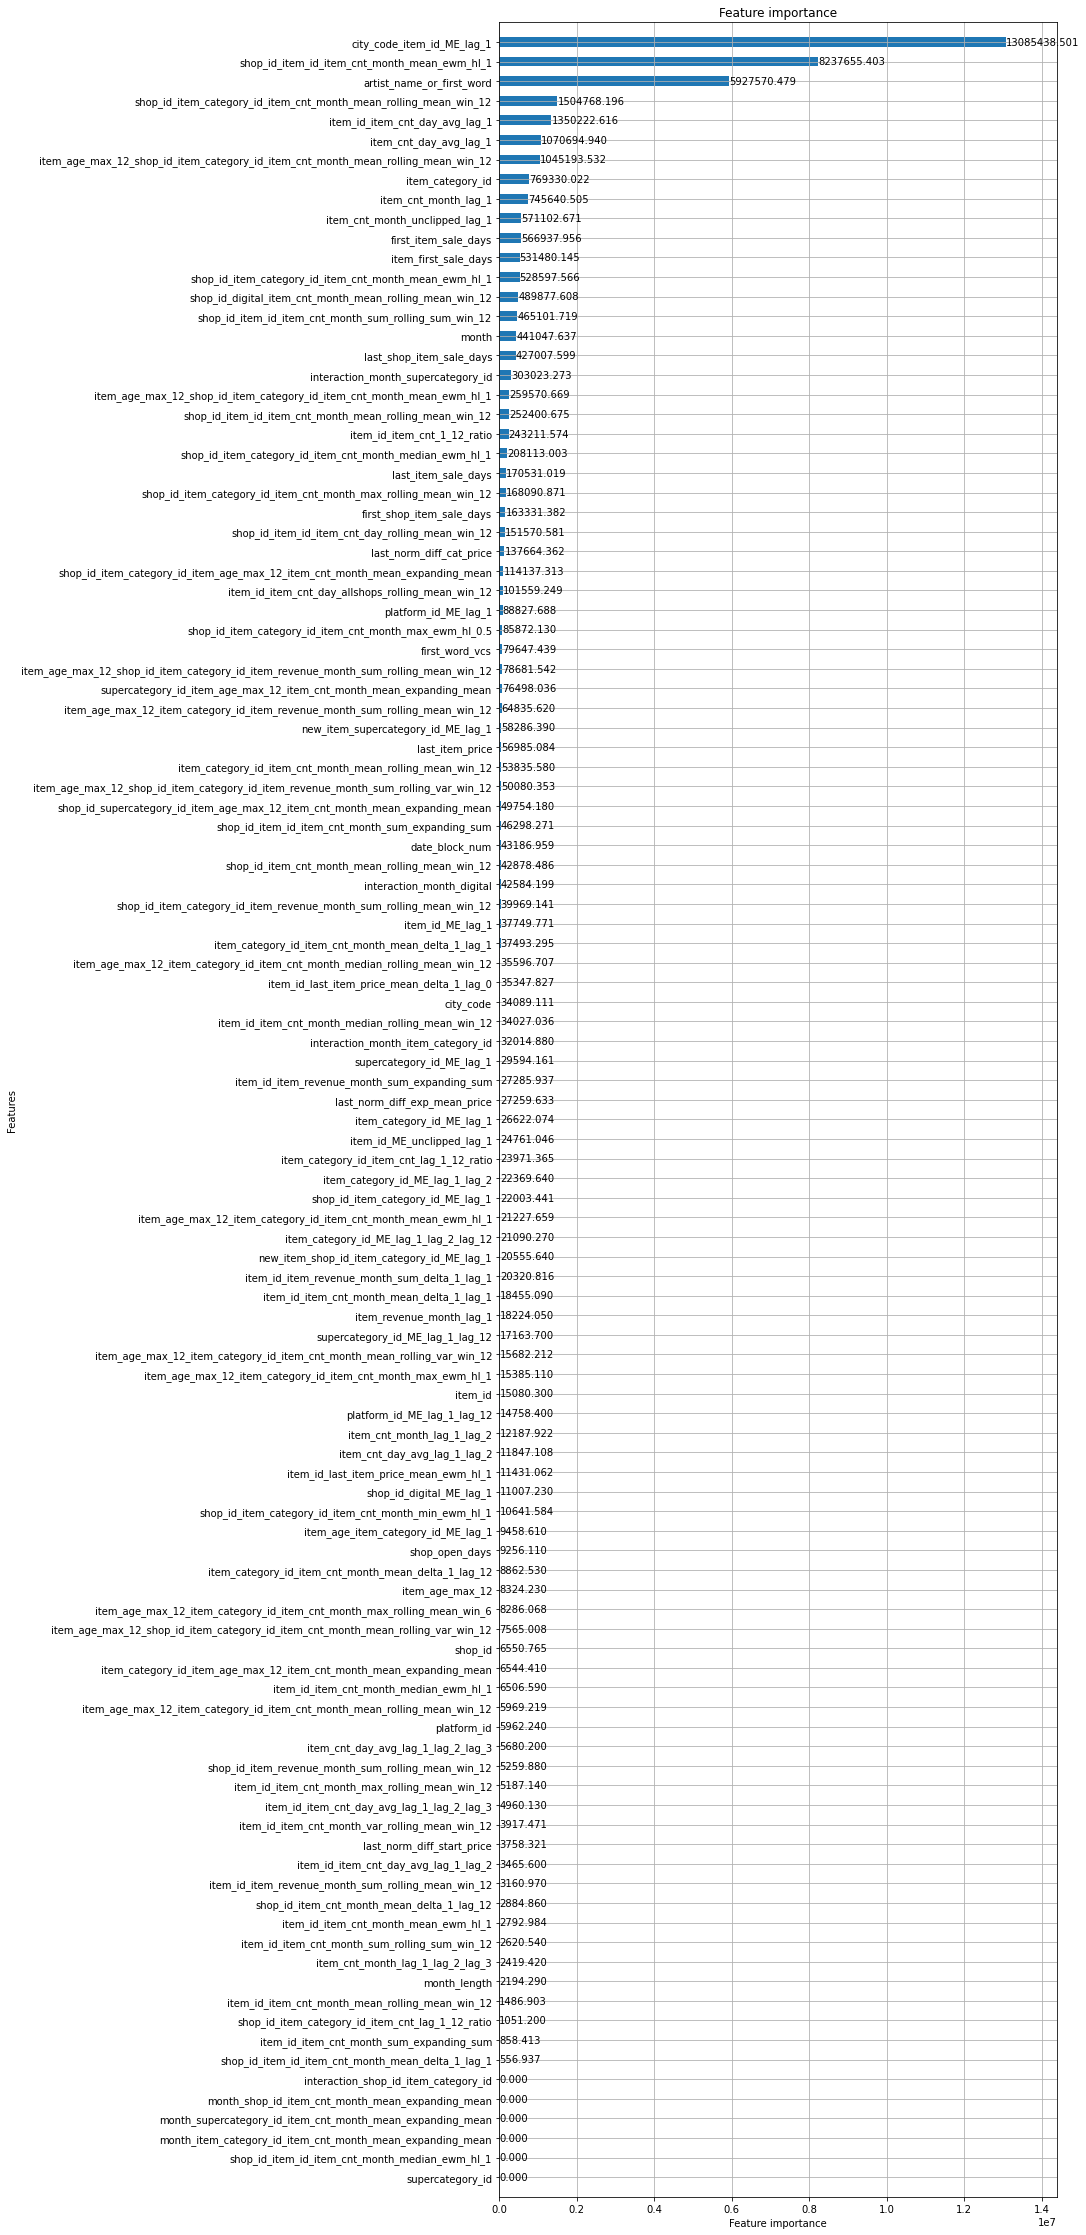

In [82]:
_ = lgbm.plot_importance(booster, figsize=(10,40), height=0.5, importance_type="gain", ignore_zero=False)

In [49]:
tophalfmask = matrix.first_word_vcs>matrix['first_word_vcs'].quantile(0.5)
matrix.loc[~tophalfmask, 'artist_name_or_first_word'] = 0

0          False
1           True
2           True
3           True
4           True
           ...  
8852976     True
8852977     True
8852978    False
8852979    False
8852980    False
Name: first_word_vcs, Length: 8852981, dtype: bool

In [ ]:
# Music artist rolling mean sale count and revenue *** ADD EXPANDING ***
matrix = add_rolling_ME(matrix, ["artist_name_or_first_word"], window=12, target_feature="item_cnt_month")
matrix = add_rolling_ME(
    matrix, ["music_artist"], window=24, target_feature="item_revenue_month", aggregation="sum"
)
print("Created categorical features")

In [ ]:
matrix, oldcols = fu.shrink_mem_new_cols(matrix, oldcols)

In [53]:
matrix.loc[matrix.new_item==False, 'item_id_item_cnt_month_mean_rolling_mean_win_12'].max()

19.666666

In [47]:
matrix.columns.to_list()

['date_block_num',
 'shop_id',
 'item_id',
 'item_cnt_month',
 'item_revenue_month',
 'item_age',
 'item_age_max_12',
 'new_item',
 'shop_age',
 'new_shop',
 'month_length',
 'first_item_date',
 'shop_open_days',
 'item_first_sale_days',
 'item_cnt_day_avg',
 'first_item_sale_days',
 'first_shop_item_sale_days',
 'last_shop_item_sale_days',
 'last_item_sale_days',
 'month',
 'item_cnt_month_unclipped',
 'last_item_price',
 'last_norm_diff_exp_mean_price',
 'last_norm_diff_start_price',
 'last_norm_diff_cat_price',
 'item_category_id',
 'digital',
 'supercategory_id',
 'platform_id',
 'city_code',
 'shop_id_item_id_item_cnt_month_mean_rolling_mean_win_12',
 'shop_id_item_id_item_cnt_month_mean_ewm_hl_1',
 'shop_id_item_id_item_cnt_month_median_ewm_hl_1',
 'item_id_item_cnt_month_mean_rolling_mean_win_12',
 'item_id_item_cnt_month_mean_ewm_hl_1',
 'item_id_item_revenue_month_sum_rolling_mean_win_12',
 'item_id_item_cnt_month_median_rolling_mean_win_12',
 'item_id_item_cnt_month_median_ew

## Minor data leak features  
i.e. counts of new and unique items in the current month  
This counts the number of unique and new items sold in the current month and also category, which could have a positive relationship to sales. As this can also be calculated for the test set (assuming that the set of test items is the set of items that were sold in the test month) this is a kind of data leak. 

In [ ]:
def add_unique_item_features(matrix):
    # Adds the number of unique and new items per month and month-category, and these values as a proportion
    unique_id_features = (
        matrix.groupby(["date_block_num", "item_category_id"])
        .item_id.nunique()
        .rename("unique_items_cat")
        .reset_index()
    )
    unique_id = (
        unique_id_features.groupby("date_block_num").unique_items_cat.sum().rename("unique_items_month")
    )
    unique_id_features = unique_id_features.merge(
        unique_id, how="left", left_on="date_block_num", right_index=True,
    )
    unique_id_features["cat_items_proportion"] = unique_id_features["unique_items_cat"].div(
        unique_id_features["unique_items_month"]
    )
    new_items_cat = (
        matrix.loc[matrix.new_item == 1, ["date_block_num", "item_id", "item_category_id"]]
        .groupby(["date_block_num", "item_category_id"])
        .item_id.nunique()
        .rename("new_items_cat")
    )
    unique_id_features = unique_id_features.merge(
        new_items_cat, left_on=["date_block_num", "item_category_id"], right_index=True, how="left",
    )
    unique_id_features["new_items_cat"] = unique_id_features["new_items_cat"].fillna(0)
    new_items_month = (
        unique_id_features.groupby("date_block_num").new_items_cat.sum().rename("new_items_month")
    )
    unique_id_features = unique_id_features.merge(
        new_items_month, left_on="date_block_num", right_index=True, how="left"
    )
    unique_id_features["cat_items_new_proportion"] = (
        unique_id_features["new_items_cat"] / unique_id_features["unique_items_cat"]
    )
    matrix = matrix.merge(unique_id_features, on=["date_block_num", "item_category_id"], how="left")
    return matrix


matrix = add_unique_item_features(matrix)

In [ ]:
gc.collect()
matrix, oldcols = fu.shrink_mem_new_cols(matrix, oldcols)
# matrix.to_pickle("matrixcheckpoint_3.pk1")
print("Saved matrixcheckpoint 3")

Sales of item with item_id one above or below (these tend to be related items)

In [ ]:
def add_neighbor_item_features(matrix, feature, group= ['item_id']):
    # Item_id minus 1
    f = matrix.groupby(["date_block_num"] + group)[feature].agg("mean")
    name_minus = "minus1_" + feature
    f.name = name_minus
    f = f.reset_index(["date_block_num"] + group)
    f["item_id"] = f["item_id"] + 1
    f['date_block_num'] += 1
    matrix = matrix.merge(f, on=["date_block_num"] + group, how='left')
    matrix[name_minus] = matrix[name_minus].fillna(99)
#     f = f.set_index(["date_block_num"] + group)[new_name]
#     f = f.reset_index(["date_block_num"] + group)
#     matrix = fu.add_lag_feature(matrix, f, group, lag=0)
#     matrix = matrix.rename(columns={new_name + '_lag_0': new_name})
    # Item_id plus 1
    name_plus = "plus1_" + feature
    f = f.rename(columns={name_minus:name_plus})
    f["item_id"] = f["item_id"] - 2
    f['date_block_num']
    matrix = matrix.merge(f, on=["date_block_num"] + group, how='left')
    matrix[name_plus] = matrix[name_plus].fillna(99)
#     f = f.set_index(["date_block_num"] + group)[new_name]
#     matrix = fu.add_lag_feature(matrix, f, group, lag=0)
#     matrix = matrix.rename(columns={new_name + '_lag_0': new_name})
    return matrix

In [ ]:
features = ["item_cnt_day_avg_lag_1", 'item_id_item_cnt_day_avg_lag_1', 'item_id_item_cnt_month_mean_rolling_mean_win_12']
for feature in features:
    matrix = add_neighbor_item_features(matrix, feature)

Item name length as a feature.

In [ ]:
import re
def clean_item_name(string):
    # Removes bracketed terms, special characters and extra whitespace
    string = re.sub(r"\[.*?\]", "", string)
    string = re.sub(r"\(.*?\)", "", string)
    string = re.sub(r"[^A-ZА-Яa-zа-я0-9 ]", "", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = string.lower()
    return string

items["item_name_cleaned_length"] = items["item_name"].apply(clean_item_name).apply(len)
items['item_name_length'] = items.item_name.apply(len)
matrix = matrix.merge(items[['item_id', 'item_name_length', 'item_name_cleaned_length']], how='left', on='item_id')

In [ ]:
gc.collect()
matrix, oldcols = fu.shrink_mem_new_cols(matrix, oldcols)
matrix.to_pickle("matrixcheckpoint_4.pk1")
print("Saved matrixcheckpoint 4")

## Similar item name values

(mention new items) this uses the fuzzy string matching package FuzzyWuzzy to find items with similar names and return sales count values for these items in their first month of availability, weighted by their similarity to the target name. Bracketed terms are stripped from the item names before matching, because these tend to contain product codes or format information (e.g. DVD, Xbox). 

In [ ]:
# items.loc[[23, 34, 12],:]

In [ ]:
# def item_name_similarity_frame(itemsdf):
#     # Makes a dataframe of similarity values between item names calculated with FuzzyWuzzy
#     # itemsdf must have a supercategory_id field
#     import re
#     from itertools import combinations

#     import scipy.sparse as sp
#     from fuzzywuzzy import fuzz

#     def strip_sq_brackets(string):
#         return re.sub(r"\[.*?\]", "", string)

#     def strip_rd_brackets(string):
#         return re.sub(r"\(.*?\)", "", string)

#     items["item_name"] = items["item_name"].apply(strip_sq_brackets).apply(strip_rd_brackets)

#     itnames = items.item_name.to_list()
#     itsupcats = items.supercategory_id.to_list()
#     pairs = combinations(items.index, 2)
#     sims = sp.dok_matrix((len(itnames), len(itnames)), dtype=np.int8)

#     for id1, id2 in tqdm(
#         pairs, total=len(itnames) * (len(itnames) - 1) / 2, desc="Calculating similarity values"
#     ):
#         if itsupcats[id1] != itsupcats[id2]:
#             pass
#         else:
#             sims[id1, id2] = fuzz.token_sort_ratio(itnames[id1], itnames[id2], force_ascii=False)

#     csims = sims.tocsr()
#     csims = csims + csims.T
#     csims = pd.DataFrame.sparse.from_spmatrix(csims)
#     return csims


# def make_sim_item_features(matrix, sim_frame, return_fields, sim_thresh=50, max_n=5, max_item_age=12):
#     storelist = []
#     mean_fields = [s + "_all_shops" for s in return_fields]
#     for date_block_num in tqdm(range(3, 35), "Generating similar item name features"):
#         for item_age in np.sort(matrix.loc[matrix.date_block_num == date_block_num, "item_age"].unique()):

#             def get_sim_item_features(item_ids):
#                 slist = []
#                 for item_id in item_ids:
#                     sim_items = sim_frame.loc[item_id, item_ids_past].nlargest(max_n)
#                     sim_items = sim_items[sim_items>sim_thresh]
#                     if len(sim_items)==0:
#                         pass
#                     else:
#                         sim_item_values = (
#                             past_months.loc[(slice(None), sim_items.index), return_fields]
#                             .groupby("shop_id")[return_fields]
#                             .mean()
#                         )
#                         sim_item_values[mean_fields] = sim_item_values.mean()
#                         sim_item_values["item_id"] = item_id
#                         slist.append(sim_item_values)
#                 sframe = pd.concat(slist)
#                 sframe["date_block_num"] = date_block_num
#                 sframe = sframe.reset_index()
#                 return sframe
#             if item_age < date_block_num:
#                 if item_age >= max_item_age:
#                     past_months = (
#                         matrix.query(f"date_block_num<{date_block_num} & date_block_num>1 & item_age>={item_age}")
#                         .groupby(["shop_id", "item_id"])[return_fields]
#                         .mean()
#                     )
#                     item_ids_past = past_months.index.get_level_values("item_id").unique()
#                     item_ids = matrix.query(
#                         f"date_block_num=={date_block_num} & item_age>={item_age}"
#                     ).item_id.unique()
#                     sframe_new = get_sim_item_features(item_ids)
#                     storelist = storelist + [sframe_new]
#                     break
#                 else:
#                     past_months = (
#                         matrix.query(f"date_block_num<{date_block_num} & date_block_num>1 & item_age=={item_age}")
#                         .groupby(["shop_id", "item_id"])[return_fields]
#                         .mean()
#                     )
#                     item_ids_past = past_months.index.get_level_values("item_id").unique()
#                     item_ids = matrix.query(
#                         f"date_block_num=={date_block_num} & item_age=={item_age}"
#                     ).item_id.unique()
#                     sframe_new = get_sim_item_features(item_ids)
#                     storelist = storelist + [sframe_new]
#     sim_item_features = pd.concat(storelist)
#     sim_item_field_names = {s: "sim_item_name_" + s for s in return_fields + mean_fields}
#     sim_item_features = sim_item_features.rename(columns=sim_item_field_names)
#     return sim_item_features


# def add_sim_item_features(matrix, sim_item_features, fill_na_val=None):
#     oldcols = matrix.columns
#     matrix = matrix.merge(sim_item_features, on=["date_block_num", "shop_id", "item_id"], how="left")
#     newcols = matrix.columns.difference(oldcols)
#     if fill_na_val is not None:
#         matrix[newcols] = matrix[newcols].fillna(fill_na_val)
#     return matrix

Add the similar item name sales features. Creating these takes ~10 hours on an i7 laptop, so previously created features can be loaded instead.

In [ ]:
# load_data = "all"  # "sim_matrix" to load the name similarity matrix then compute new features, and "all" to load the features.
# if load_data not in ["all", "sim_matrix"]:
#     items = pd.read_csv("../input/competitive-data-science-predict-future-sales/items.csv")
#     items = items.merge(
#         item_categories_extra[["item_category_id", "supercategory_id"]], on="item_category_id", how="left"
#     )
#     sim_matrix = item_name_similarity_frame(items)
# elif load_data == "sim_matrix":
#     sim_matrix = pd.read_pickle("../input/predict-future-sales-extra/sim_frame_no_brackets.pk1")
#     sim_item_features = make_sim_item_features(matrix, sim_matrix, ["item_cnt_month", "item_cnt_day_avg"], sim_thresh=70, max_n=5)
#     sim_item_features.to_csv("sim_item_features_w_missing.csv.gz")
# elif load_data == "all":
#     sim_item_features = pd.read_csv("../input/predict-future-sales-extra/sim_item_features_w_missing.csv")

# matrix = add_sim_item_features(matrix, sim_item_features)

# missingmask = matrix["sim_item_name_item_cnt_month"].isna()
# matrix.loc[missingmask, "sim_item_name_item_cnt_month"] = matrix.loc[
#     missingmask, "shop_id_supercategory_id_item_age_max_12_item_cnt_month_mean_expanding_mean"
# ]
# missingmask = matrix["sim_item_name_item_cnt_month_all_shops"].isna()
# matrix.loc[missingmask, "sim_item_name_item_cnt_month_all_shops"] = matrix.loc[
#     missingmask, "supercategory_id_item_age_max_12_item_cnt_month_mean_expanding_mean"
# ]
# del(sim_item_features)
# gc.collect()

Use the mean for the supercategory / age combination to fill in missing similar name sales values for cases when no similar names were found, additionally leave the supercategory / age mean as a new feature.

In [ ]:
# matrix, oldcols = fu.shrink_mem_new_cols(matrix, oldcols)
# matrix.to_pickle("matrixcheckpoint_5.pk1")

In [ ]:
%reset -f

# Model fitting section

In [ ]:
import gc
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

import lightgbm as lgbm

In [ ]:
import pandas as pd

In [ ]:
matrix = pd.read_pickle("matrixcheckpoint_4.pk1")

### Generate train, validation, test sets from feature matrix

In [52]:
def train_test_x_y(
    matrix, test_month, keep_from_month=3, new_target=None
):
    if new_target is not None:
        matrix["item_cnt_month"] = matrix.loc[:, new_target]
        matrix = matrix.drop(columns=new_target)

    def split_train_test(matrix, test_month=33):
        # Split the matrix into train and test sets.
        test = matrix.loc[matrix.date_block_num==test_month, :]
        train = matrix.loc[matrix.date_block_num < test_month, :]
        return train, test

    def xysplit(matrix):
        # Split a train and test set into into x and y sets, with item_cnt as the target y variable
        y = matrix.item_cnt_month
        X = matrix.drop(columns=["item_cnt_month"])
        return (X, y)

    matrix = matrix.drop(
        columns=[
            "item_revenue_month",
            "item_price",
            "item_cnt_month_original",
            "item_cnt_month_unclipped",
            "item_cnt_day_avg",
            "new_item",
            "new_shop",
            "item_age",
            "shop_age",
            "digital",
            "first_item_date",
        ],
        errors="ignore",
    )

    train, test = split_train_test(matrix, test_month)
    train = train[train.date_block_num >= keep_from_month]
    X_train, y_train = xysplit(train)
    X_test, y_test = xysplit(test)
    return (X_train, y_train, X_test, y_test)

In [53]:
def censor_lag_features(matrix, candidate_features, replacement_val = 9999):
    # replace any lag features which are invalid due to the shop / item age being less than the lag
    def item_lag_feats(lag):
        return [
            f
            for f in candidate_features
            if f"lag_{lag}" in f
            and "item" in f
            and f[:4] != "shop"
            and "category" not in f
            and "city" not in f
            and "minus" not in f
            and "plus" not in f
            and "sim" not in f
        ]

    def shop_lag_feats(lag):
        return [
            f
            for f in candidate_features
            if f"lag_{lag}" in f
            and "shop" in f
            and "category" not in f
            and "city" not in f
            and "minus" not in f
            and "plus" not in f
            and "sim" not in f
        ]

    lags = range(1,13)
    for lag in lags:
        lag_feats = shop_lag_feats(lag)
        matrix.loc[matrix.shop_age < lag, lag_feats] = replacement_val
        lag_feats = item_lag_feats(lag)
        matrix.loc[matrix.item_age < lag, lag_feats] = replacement_val
    return matrix

In [65]:
import warnings

import numpy as np
import optuna
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore", module="lightgbm")

import lightgbm as lgbm

def fit_booster(matrix, params=None, test_run = False, categoricals=[], dropcols=[]):
    # Regular booster fitting function
    if params is None:
        params = {
            "boosting_type": "gbdt",
            "device_type": "cpu",
            "n_jobs": 11,
            "learning_rate": 0.1,
            "n_estimators": 1000,
        }

    matrix = censor_lag_features(matrix, matrix.columns, replacement_val=9999)

    if test_run:
        test_month = 34
        early_stopping_rounds=None
    else:
        test_month = 33
        early_stopping_rounds=int(1/params['learning_rate'])    
    
    X_train, y_train, X_test, y_test = train_test_x_y(
        matrix.drop(columns=dropcols), test_month=test_month, keep_from_month=1,
    )

    if test_run:
        eval_set=[(X_train, y_train)]
    else:
        eval_set=[(X_train, y_train), (X_test, y_test)]

    booster = lgbm.LGBMRegressor(**params)

    booster.fit(
        X_train,
        y_train,
        eval_set=eval_set,
        eval_metric=["rmse"],
        verbose=10,
        categorical_feature=categoricals,
        early_stopping_rounds=early_stopping_rounds
    )

    if test_run:
        X_test['item_cnt_month'] = booster.predict(X_test)
        return booster, X_test
    else:
        return booster

In [ ]:
import optuna
from sklearn.metrics import mean_squared_error

import lightgbm as lgbm

class Objective(object):
    def __init__(self, matrix):
        matrix = censor_lag_features(matrix, matrix.columns, replacement_val=9999)
        self.X_train, self.y_train, self.X_valid, self.y_valid = train_test_x_y(
            matrix, test_month=33, keep_from_month=2,
            )

    def __call__(self, trial):
        params = {
            "boosting_type": "gbdt",
            "device_type": "cpu",
            "n_jobs": 11,
            "silent": True,
            "n_estimators": 1000,
            "learning_rate": 0.1,
            "bagging_seed": 3,
            "subsample_for_bin": 300000,
            "max_depth": -1,
            "min_data_in_bin": 1,
            "num_leaves": trial.suggest_int("num_leaves", 255, 2048, log=True),
            "cat_smooth": trial.suggest_float("cat_smooth", 10, 100, log=True),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 1.0),
            "min_child_samples": trial.suggest_int("min_child_samples", 1, 10),
            "min_child_weight": trial.suggest_float("min_child_weight", 0.001, 2, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "subsample_freq": trial.suggest_int("subsample_freq", 1, 8),
            "max_bin": trial.suggest_int("max_bin", 16, 255, log=True),
        }

        categoricals = [
            "shop_id",
            "item_category_id",
            "city_code",
            "month",
            "interaction_month_digital",
            "interaction_month_item_category_id",
        ]
        
        categoricals = [c for c in categoricals if c in self.X_train.columns]
        
        early_stopping_rounds=int(1/params['learning_rate'])
        
        # Add a callback for pruning.
        pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "rmse")

        booster = lgbm.LGBMRegressor(**params)

        booster.fit(
            self.X_train,
            self.y_train,
            eval_set=[(self.X_valid, self.y_valid)],
            eval_metric=["rmse"],
            callbacks=[pruning_callback],
            verbose=False,
            categorical_feature=categoricals,
            early_stopping_rounds=early_stopping_rounds
            
        )

        predictions = booster.predict(self.X_valid)
        rmse = mean_squared_error(self.y_valid, predictions.clip(0,20), squared=False)

        return rmse


import warnings

# warnings.filterwarnings("ignore", message="", module="lightgbm", lineno=1286)
warnings.filterwarnings("ignore", message="", module="lightgbm")

study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=15), direction="minimize")
study.optimize(Objective(matrix), n_trials=100, gc_after_trial=True)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
import gc
gc.collect()

In [ ]:
import joblib
joblib.dump(study, "optuna_results_21.03.2021.pk1")

In [ ]:
print("finished everything!")